In [1]:
import json
import pprint
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
patient = 504
source_type = 'validate'
image_size = 176

In [3]:
filepath = "/masvol/output/dsb/volume/1"
filename = "{0}/1combined_1_1_{1}_dice_drop_32B/{2}_{3}_{1}.json".format(filepath,image_size,source_type,patient)

In [4]:
!ls $filename

/masvol/output/dsb/volume/1/1combined_1_1_176_dice_drop_32B/validate_504_176.json


In [5]:
jin = None
with open(filename, 'r') as inputs:
    jin = json.load(inputs)
    #print (jin, type(jin))

#### maxSL = max slice location
#### minSL = min slice location
#### zmax = max ones count
#### zmin = min ones count
#### We were counting zeroes so the z letter stuck to be part of the variable name.  But the counts are for ones from the predictions
#### Some don't have any prediction so you see zmax 0 or zmin 0 with maxSL = None and zmaxframe = ''

In [6]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(jin)

{   'sax_12': {   'maxSL': -35.057466944811374,
                  'maxST': 8.0,
                  'minSL': -35.057466944811374,
                  'minST': 8.0,
                  'zcounts': [   472,
                                 469,
                                 494,
                                 79,
                                 419,
                                 558,
                                 198,
                                 93,
                                 401,
                                 2,
                                 420,
                                 96,
                                 10,
                                 371,
                                 341,
                                 415,
                                 225,
                                 16,
                                 406,
                                 39,
                                 0,
                                 8,
                

In [7]:
dcmarraypath = "/masvol/output/dsb/norm/1/1"
dcmfilepath = "{0}/{1}/{2}".format(dcmarraypath,source_type,patient)

In [8]:
#!ls $dcmfilepath/sax_56_IM-6380-0009.dcm.npy

In [9]:
def apply_sort(jin):
    sldict = dict()
    
    for sax in jin:
        maxsl = jin[sax]['maxSL']
        minsl = jin[sax]['minSL']
        slkey = None
        
        if minsl is not None:
            slkey = minsl
        elif maxsl is None:
            continue
        else:
            slkey = maxsl
                
        sldict.update({slkey:sax})
    
    slarray = []
    
    for sl in reversed(sorted(sldict)):
        slarray.append((sl,sldict[sl]))
    
    return slarray

### Sorted by slice location

In [10]:
sjin = apply_sort(jin)
sjin

[(-35.057466944811374, 'sax_12'),
 (-45.057466236986464, 'sax_13'),
 (-55.05746486456107, 'sax_14'),
 (-65.05746335329923, 'sax_15'),
 (-75.05746369119299, 'sax_16'),
 (-85.05746402909341, 'sax_17'),
 (-95.05746436698662, 'sax_18'),
 (-105.05746470487985, 'sax_19'),
 (-115.05746478135245, 'sax_20'),
 (-125.05746351237465, 'sax_21'),
 (-135.05746385026788, 'sax_22')]

In [11]:
image_path = "{0}/unet_model_{1}/data/dsb_{2}_image_path.txt".format(dcmarraypath,source_type,patient)
image_array = []

with open (image_path, 'r') as filepath:
    for i in filepath:
        i = i.strip()
        image_array = [x.replace("{0}/{1}/{2}/".format(dcmarraypath,source_type,patient),"") 
                       for x in i.split(',')]

### Showing the original dicom end-systolic and end-diastolic images identified in each slice

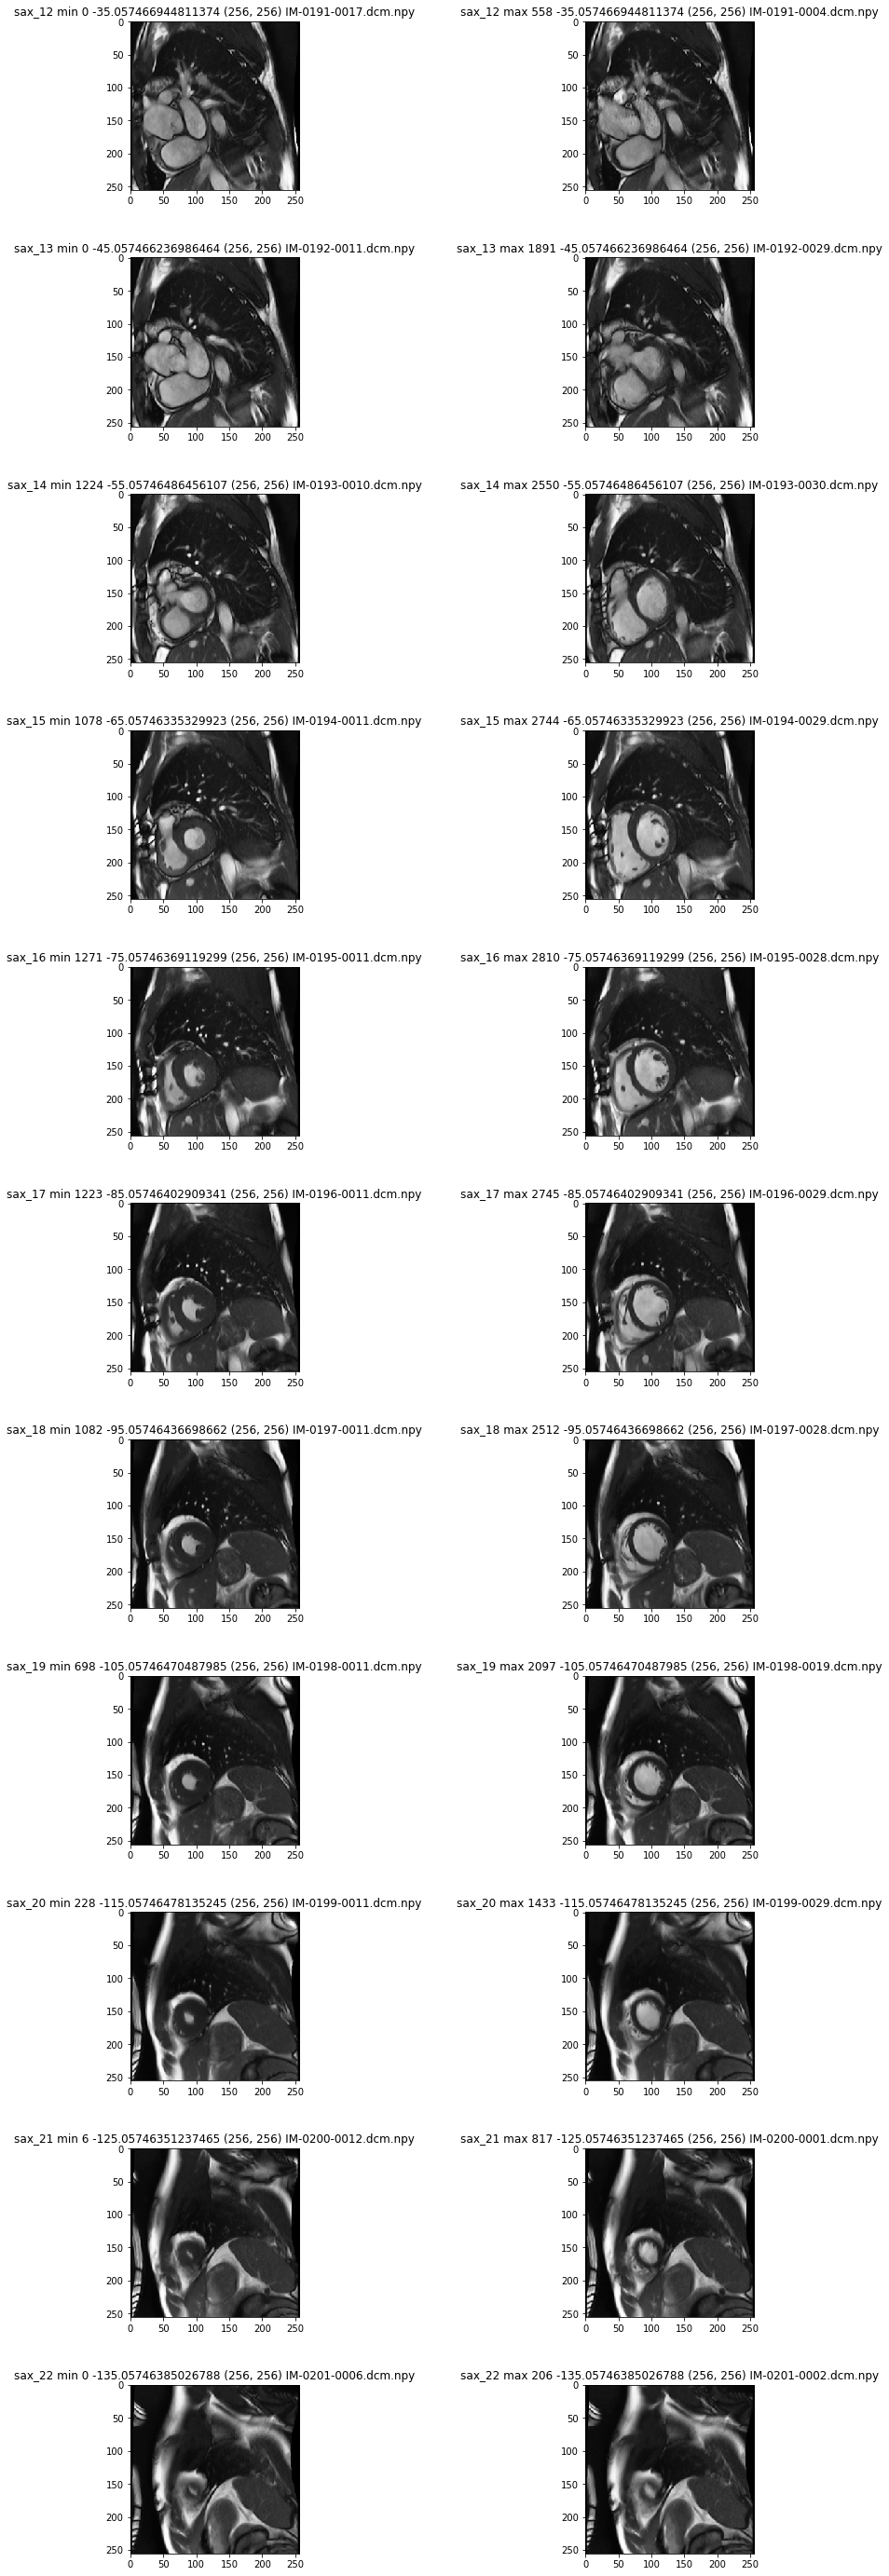

In [12]:
rowcount = len(jin.keys())
display_list = []

scount = 0

fig = plt.figure(figsize=(15,50))
fig.subplots_adjust(hspace=0.4, wspace=0.4);

for sl, sax in sjin:
    maxsl = jin[sax]['maxSL']
    minsl = jin[sax]['minSL']
    minones = jin[sax]['zmin']
    maxones = jin[sax]['zmax']
    minframe = jin[sax]['zminframe']
    maxframe = jin[sax]['zmaxframe']
    dcmfilemin = "{0}/{1}/{2}/{3}_{4}".format(dcmarraypath,source_type,patient,sax,minframe)
    dcmfilemax = "{0}/{1}/{2}/{3}_{4}".format(dcmarraypath,source_type,patient,sax,maxframe)
    minimg = []
    maximg = []
    scount += 1
    tempfile = "{0}_{1}".format(sax, minframe)
    
    if tempfile in image_array:
        display_list.append((image_array.index(tempfile),minones))
    
    tempfile = "{0}_{1}".format(sax, maxframe)
    
    if tempfile in image_array:
        display_list.append((image_array.index(tempfile),maxones))
    
    if os.path.isfile(dcmfilemin):
        minimg = np.load(dcmfilemin)

    if os.path.isfile(dcmfilemax):
        maximg = np.load(dcmfilemax)

    ax = fig.add_subplot(rowcount, 2, scount)
    
    try:
        title1 = "{0} min {1} {2} {3} {4}".format(sax,minones,minsl,minimg.shape, minframe)
        ax.imshow(minimg, cmap = 'gray')
    except:
        title1 = "{0} {1} {2} {3}".format(sax,minones,minsl,minframe)
        
    ax.set_title(title1)
    scount += 1
    
    ax = fig.add_subplot(rowcount, 2, scount)
    
    try:
        title2 = "{0} max {1} {2} {3} {4}".format(sax,maxones,maxsl,maximg.shape, maxframe)
        ax.imshow(maximg, cmap = 'gray')
    except:  
        title2 = "{0} {1} {2} {3}".format(sax,maxones,maxsl,maxframe)
        
    ax.set_title(title2)
    
plt.show()

In [13]:
filepath = "/masvol/output/dsb/norm/1/1/unet_model_{0}/".format(source_type)
#combined_1_1_176_dice_aug_drop_32B_models/dsb_{1}_{2}".format(source_type,patient,image_size)
#!ls $filepath*

In [14]:
ts = np.load("{0}/combined_1_1_176_dice_aug_drop_32B_predict_CR/dsb_{1}_{2}_CR_ts_norm.npy".format(filepath,patient,image_size))

In [15]:
predictions = np.load("{0}/combined_1_1_176_dice_aug_drop_32B_predict_CR/dsb_{1}_{2}_CR_predictions_cleaned.npy".format(filepath,patient,image_size))
pred2 = np.load("{0}/combined_1_1_176_dice_aug_drop_32B_predict_CR/dsb_{1}_{2}_CR_pred_round.npy".format(filepath,patient,image_size))

In [16]:
samples, x, y, z = predictions.shape

### Showing the corresponding end-systolic and end-diastolic predicted images 

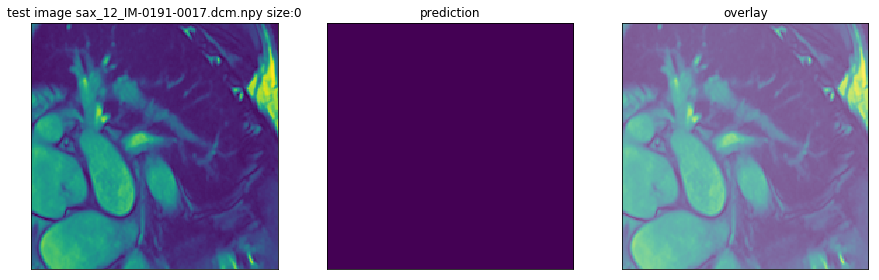

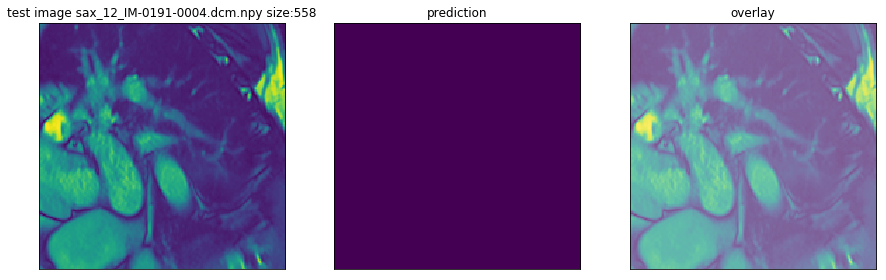

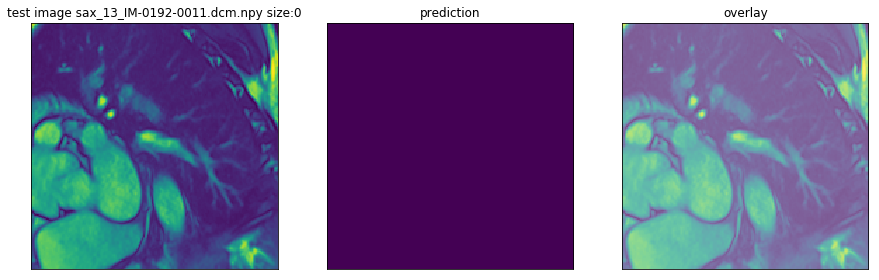

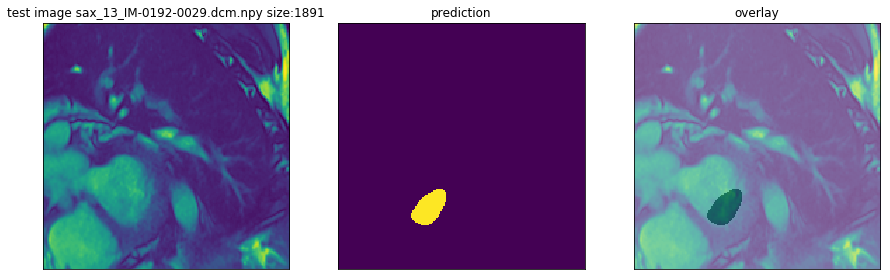

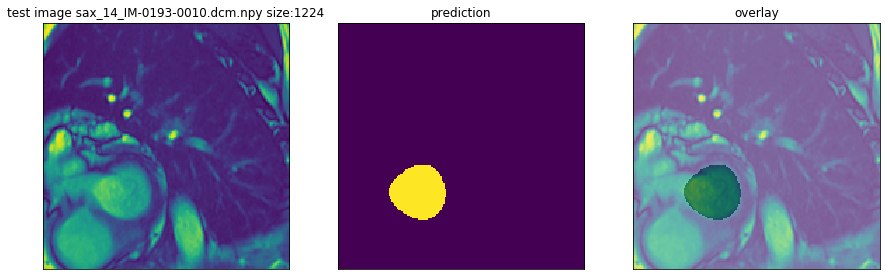

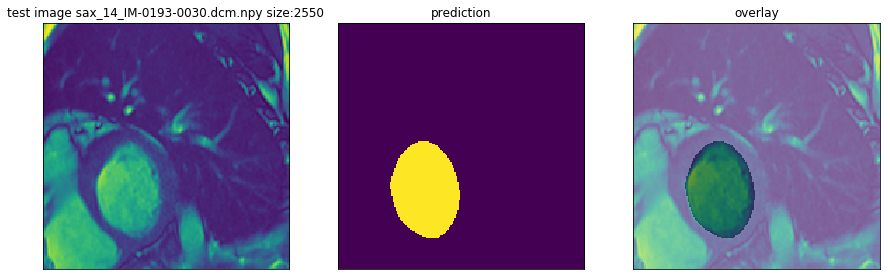

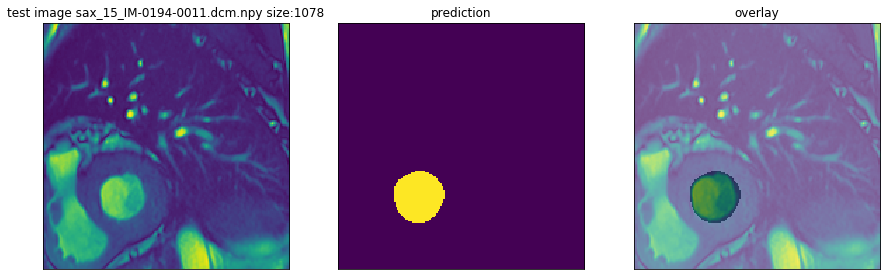

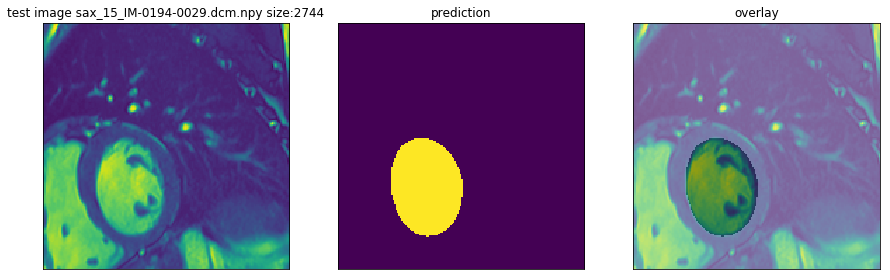

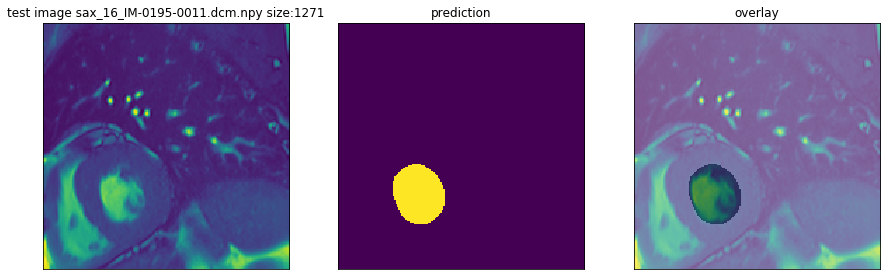

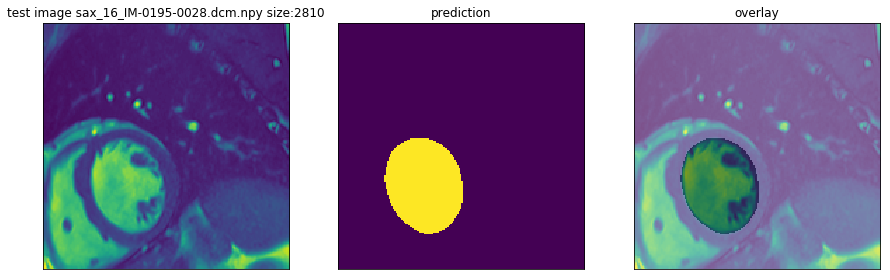

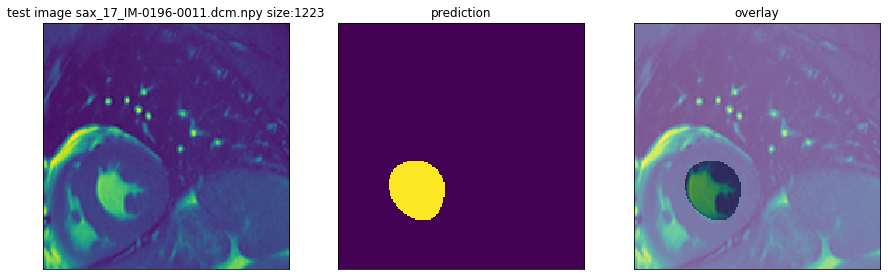

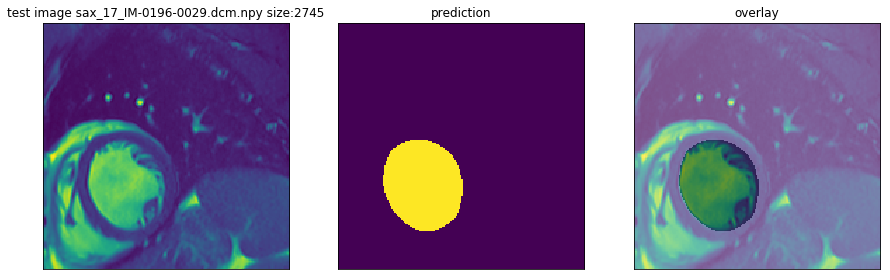

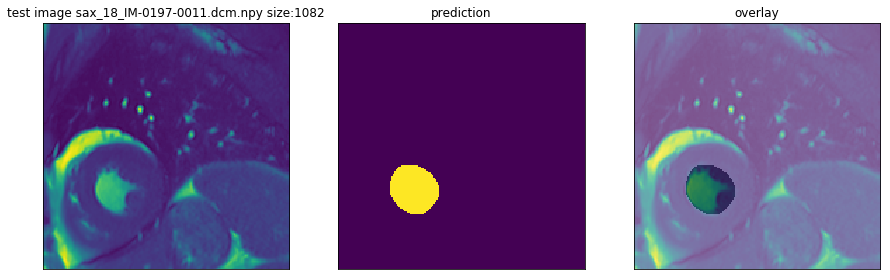

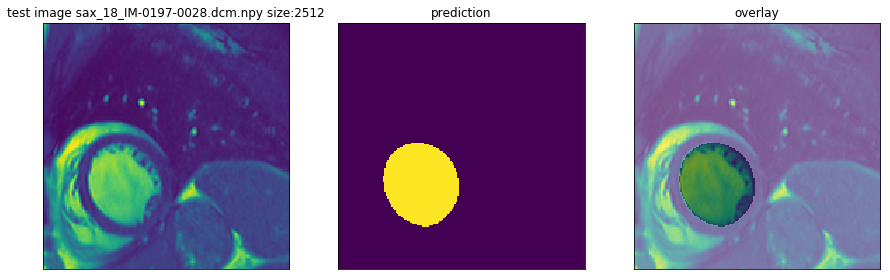

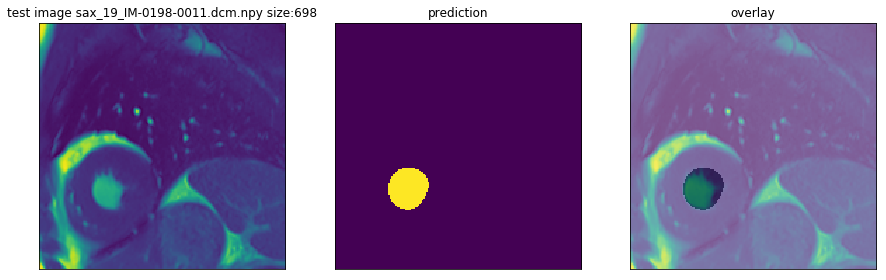

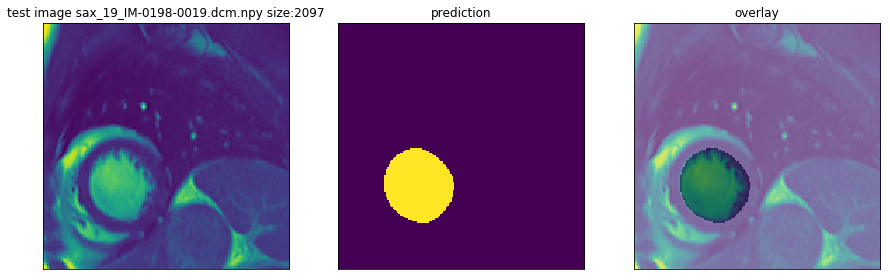

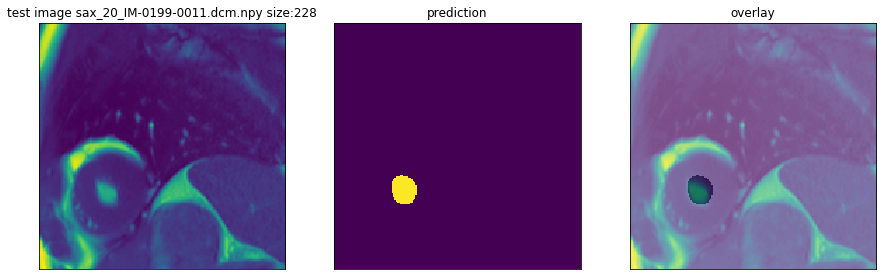

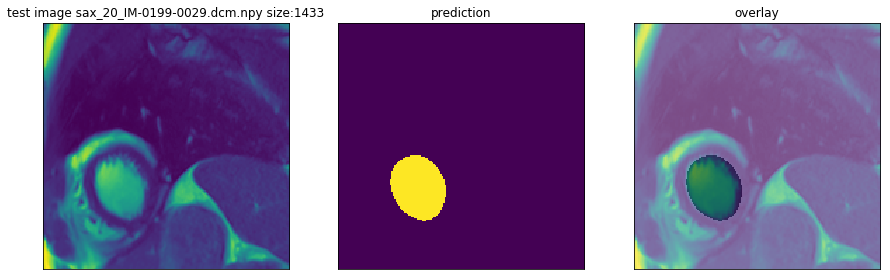

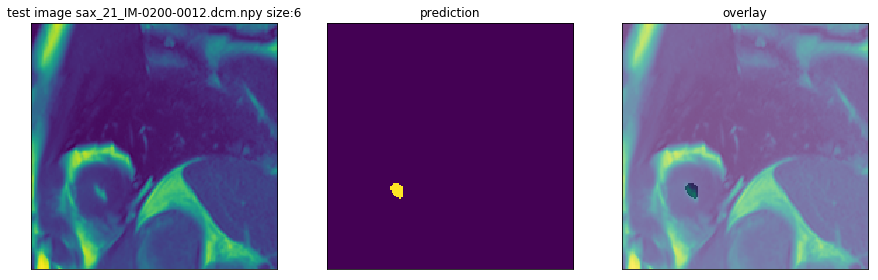

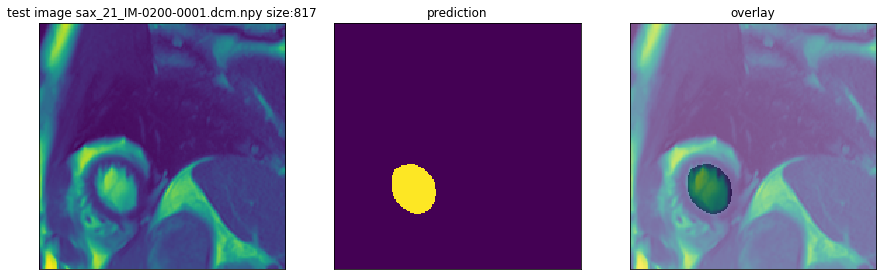

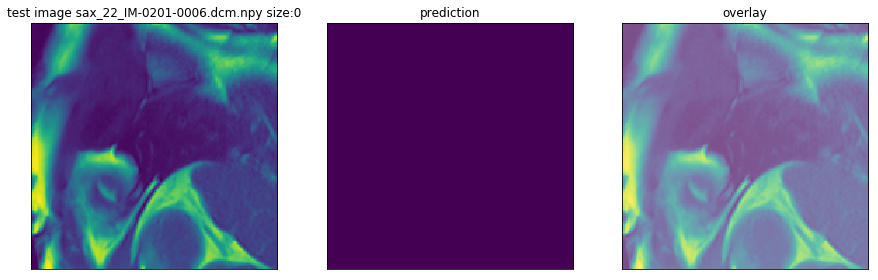

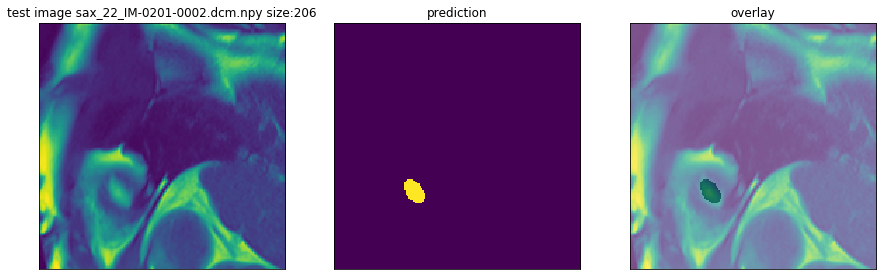

In [17]:
for i,ones in display_list:
    f, axs = plt.subplots(1,3,figsize=(15,15))
    plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
    plt.title('test image {0} size:{1}'.format(image_array[i],ones))
    plt.xticks([]), plt.yticks([])
    
    plt.subplot(132),plt.imshow(pred2[i].reshape(x, y))
    plt.title('prediction'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), 
    plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
    plt.title('overlay'), plt.xticks([]), plt.yticks([])
    plt.show()

In [18]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show code on/off"></form>''')